# **ENEL645 Project - Driver drowsiness detection**
## Group 6


In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, Dropout, MaxPool2D, Flatten, Dense, Activation

## 0. Connecting services
### Loading google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading TensorBoard

In [3]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 1. Data preprocessing
### 1.1 See labels

In [4]:
dataset_path = 'gdrive/MyDrive/ENEL-645/Project/dataset'
labels = os.listdir(dataset_path + "/train")
labels

['Closed', 'no_yawn', 'Open', 'yawn']

### 1.2 Load dataset with real-time augmentation

In [5]:
batch_size = 16
# gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
#               "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
#               "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
#                "cval": 0}               
dev_datagen = ImageDataGenerator(rescale = 1./255, 
                                  validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
dev_data_path = dataset_path + '/train'
test_data_path = dataset_path + '/test'

train_generator = dev_datagen.flow_from_directory(dev_data_path, 
                                             target_size = (256,256),
                                             batch_size = batch_size, 
                                             color_mode = 'rgb',
                                             class_mode = 'categorical',
                                             subset = 'training')

val_generator = dev_datagen.flow_from_directory(dev_data_path,
                                           target_size = (256,256),
                                           batch_size = batch_size, 
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           subset = 'validation')

test_generator = test_datagen.flow_from_directory(test_data_path, 
                                             target_size = (256,256),
                                             batch_size = batch_size, 
                                             color_mode = 'rgb',
                                             class_mode = 'categorical')

Found 2223 images belonging to 4 classes.
Found 244 images belonging to 4 classes.
Found 433 images belonging to 4 classes.


### 1.3 Dataset exploring

In [7]:
print(f"Train set labels: {train_generator.labels}")
print(f"Test set labels: {test_generator.labels}")
print(f"Sample image (from batch 1 (X, y) tuple) shape: {train_generator[0][0].shape}")
# To examine a scaling is inplace
print(f"Max value in X from batch 1 first image: {train_generator[0][0].max()}")
# Just to show that there are on-hot encoding inplace
print(f"Encoding sample from batch 1 first 5 images: {train_generator[0][1][:5]}")

Train set labels: [0 0 0 ... 3 3 3]
Test set labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Sample image (from batch 1 (X, y) tuple) shape: (16, 256, 256, 3)
Ma

###1.4 Displaying some images

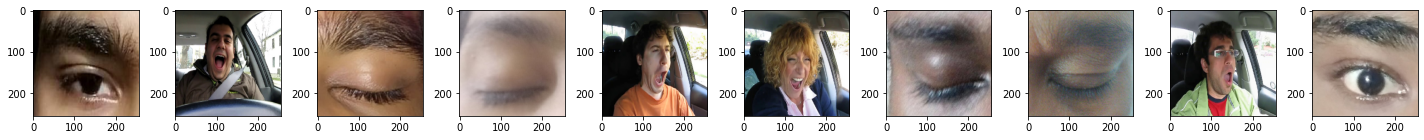

In [8]:
%matplotlib inline

def plot_imgs():
    item_files = train_generator[0][0][:10]
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(item_files):
        plt.subplot(10, 10, i+1)
        plt.tight_layout()         
        plt.imshow(image, cmap='gray') 

plot_imgs()

## 2. CNN model for classification without feature extraction
### 2.1 Define model, cost function, optimizer, and learning rate

In [9]:
# Experiment with different network architectures, learnig rates, dropout, etc.
def cnn(ishape = (256,256,3),k = 4, lr = 1e-2):
  model = Sequential()
  model.add(Input(ishape))
  
  model.add(Conv2D(64, (3,3), activation = 'relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Conv2D(40, (3,3), activation = 'relu'))
  model.add(MaxPool2D((2,2)))
  
  model.add(Conv2D(32, (3,3), activation = 'relu'))
  model.add(MaxPool2D((2,2)))
  
  model.add(Conv2D(20, (3,3), activation = 'relu'))
  model.add(MaxPool2D((2,2)))
  
  model.add(Conv2D(16, (3,3), activation = 'relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Flatten())
  model.add(Dropout(0.5))

  model.add(Dense(128, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
  return model

In [10]:
model = cnn()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 40)      23080     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        11552     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 20)        5

### 2.2. Define callbacks (save model, patience, etc.)

In [11]:
model_name_cnn = "project_CNN.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### 2.3 Train model

In [ ]:
batch_size=32
n_epoch = 100
training_steps=train_generator.n//train_generator.batch_size
validation_steps =val_generator.n//val_generator.batch_size
model.fit(x=train_generator,
          validation_data=val_generator,
          batch_size=batch_size, 
          epochs=n_epoch,
          verbose=1,
          steps_per_epoch=training_steps,
          validation_steps=validation_steps,
          callbacks = [early_stop, monitor, lr_schedule, tensorboard_callback])

Epoch 1/100
138/138 [==============================] - 295s 2s/step - loss: 0.9916 - accuracy: 0.4828 - val_loss: 0.7312 - val_accuracy: 0.7042
Epoch 2/100
138/138 [==============================] - 292s 2s/step - loss: 0.4910 - accuracy: 0.7591 - val_loss: 0.5574 - val_accuracy: 0.5792
Epoch 3/100
138/138 [==============================] - 295s 2s/step - loss: 0.4081 - accuracy: 0.8098 - val_loss: 0.4634 - val_accuracy: 0.7708
Epoch 4/100
138/138 [==============================] - 291s 2s/step - loss: 0.4062 - accuracy: 0.7980 - val_loss: 0.7555 - val_accuracy: 0.6167
Epoch 5/100
138/138 [==============================] - 291s 2s/step - loss: 0.3628 - accuracy: 0.8035 - val_loss: 0.6232 - val_accuracy: 0.5958
Epoch 6/100
138/138 [==============================] - 292s 2s/step - loss: 0.3377 - accuracy: 0.8321 - val_loss: 0.6796 - val_accuracy: 0.6083
Epoch 7/100
138/138 [==============================] - 291s 2s/step - loss: 0.3677 - accuracy: 0.8254 - val_loss: 0.7972 - val_accuracy:

In [ ]:
model.save(f'gdrive/MyDrive/ENEL-645/Project/Midterm/{model_name_cnn}')

### 2.4 Test model

In [ ]:
model.load_weights(f'gdrive/MyDrive/ENEL-645/Project/Midterm/{model_name_cnn}')
metrics = model.evaluate(test_generator)

# Ypred = model.predict(test_generator).argmax(axis = 1)
# wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
# print(wrong_indexes.size)

# # Disaplying some samples from the development set
# sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
# plt.figure(figsize = (24,18))
# for (ii,jj) in enumerate(sample_indexes):
#     plt.subplot(5,6,ii+1)
#     plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
#     plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
# plt.show()

In [ ]:
# run TensorBoard
%tensorboard --logdir logs/fit

##  **Team members participtaion**
All members contributed to the assignment equally